In [1]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools

import Base: show

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.


In [2]:
function filtering_model()
    model = Model()
    
    x_prev = datavar(model, :x_prior, NormalMeanVariance{Float64})
    add_1  = constvar(model, :add_1, 1.0)
    x      = randomvar(model, :x)
    
    x_prev_add = make_node(model, +, x, add_1, x_prev)
    
    noise = constvar(model, :noise, NormalMeanVariance(0.0, 200.0))
    y     = datavar(model, :y, Dirac{Float64})
    
    add_x_and_noise = make_node(model, +, y, x, noise)
    
    activate!(model)
    
    return x_prev, x, y
end

function filtering(data)
    N = length(data)
    
    x_prev, x, y = filtering_model()
    
    marginals = Vector{NormalMeanVariance{Float64}}()
    
    subscription = subscribe!(getmarginal(x), (t) -> begin
        update!(x_prev, as_message(getdata(t)))
        push!(marginals, getdata(t))
    end)
    
    update!(x_prev, NormalMeanVariance(0.0, 10000.0))
    
    for d in data
        update!(y, d)
    end
    
    unsubscribe!(subscription)
    
    return marginals
end

filtering (generic function with 1 method)

In [3]:
N = 600
data = collect(1:N) + sqrt(200.0) * randn(N);

In [4]:
@time filtering(data); # Initial compilation

  2.385530 seconds (6.66 M allocations: 358.913 MiB, 4.14% gc time)


In [5]:
@time filtering(data); # Subsequent runs

  0.001551 seconds (20.36 k allocations: 1.037 MiB)


In [6]:
@btime filtering($data); # Performance benchmark

  744.437 μs (20362 allocations: 1.04 MiB)


In [7]:
using Plots

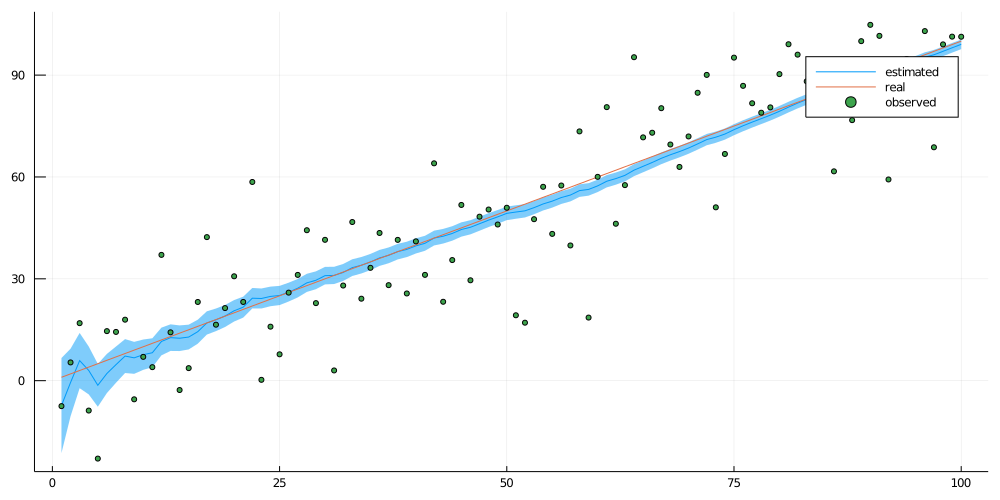

In [8]:
real_data = collect(1:100)
obs_data  = real_data .+ (sqrt(200.0) * randn(100));
estimated = filtering(obs_data)

graph = plot(mean.(estimated), ribbon = std.(estimated), label = :estimated)
graph = plot!(graph, real_data, label = :real)
graph = scatter!(graph, obs_data, ms = 3, label = :observed)

plot(graph, size = (1000, 500))

In [9]:
filtering(data)

600-element Array{NormalMeanVariance{Float64},1}:
 NormalMeanVariance{Float64}(μ=10.479966425381992, v=196.07843137254903)
 NormalMeanVariance{Float64}(μ=6.03331991040806, v=99.009900990099)
 NormalMeanVariance{Float64}(μ=0.9049291948690927, v=66.22516556291389)
 NormalMeanVariance{Float64}(μ=1.0401305625665076, v=49.751243781094516)
 NormalMeanVariance{Float64}(μ=4.998062778045994, v=39.840637450199196)
 NormalMeanVariance{Float64}(μ=9.13137208027403, v=33.22259136212624)
 NormalMeanVariance{Float64}(μ=9.909422017681054, v=28.490028490028482)
 NormalMeanVariance{Float64}(μ=15.209110634785137, v=24.937655860349118)
 NormalMeanVariance{Float64}(μ=15.769917521244762, v=22.17294900221729)
 NormalMeanVariance{Float64}(μ=14.27256244211937, v=19.96007984031936)
 NormalMeanVariance{Float64}(μ=17.56068797679676, v=18.148820326678763)
 NormalMeanVariance{Float64}(μ=18.077661113283302, v=16.638935108153074)
 NormalMeanVariance{Float64}(μ=18.841406161458274, v=15.360983102918581)
 ⋮
 NormalMeanVa